In [1]:
import os, sys
import glob
import numpy as np
import netCDF4 as nc

import pandas as pd, xarray as xr

# ----------------------------
# set plotting styles
import colorcet as cc
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

rc = {"font.family": "serif", "mathtext.fontset": "stix", 'font.size': 16, 'axes.labelsize': 18}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
# TODO check sunglint component from OSOAA check OSOAA_SOS_CORE_harmel.F line 2181 or 3982

# ----------------------------

import coxmunk 

opj = os.path.join

## Statistics used in Cox and Munk model:
- `cm_iso`, original isotropic Cox Munk statistics
- `cm_dir`, historical values from directional COX MUNK
- `bh2006`, reassessment from Breon Henriot 2006 JGR

In [2]:
stats = 'cm_iso'

## Settings
- slope if True: output figure of wave slope values
- shadow if True: computation of the hiding and shadowing effects of wave heights

In [4]:
sza_ = 40
wind = 4
wind_azi = 0

shadow = False
slope = False

vza = np.linspace(0, 80, 41)
azi = np.linspace(0, 360, 181)
Nvza, Nazi =  len(vza), len(azi)
if slope:
    titles = ('$Z_{up}$', '$Z_{cr}$', '$R_f$','Pdist')
    N = 4
else:
    titles = ('I', 'Q', 'U')
    N=4
data = np.zeros((Nazi, Nvza, N))

for i in range(Nvza):
    for j in range(Nazi):
        data[j, i, :] = coxmunk.sunglint(sza_,vza[i],azi[j], m=1.334).sunglint(
            wind, wind_azi, stats=stats, shadow=shadow, slope=slope)

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/coxmunk/coxmunk.py:240: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(ang)


In [5]:
data[np.abs(data)<1e-5]=0

In [6]:
Rsunglint = xr.Dataset(dict(L_Rsunglint=(["azi", "vza"], data[...,0]),
               Q_Rsunglint=(["azi", "vza"], data[...,1]),
               U_Rsunglint=(["azi", "vza"], data[...,2]),),
                                      coords=dict(
                                          vza=vza,
                                          azi=azi,
                                          sza=sza,
                                          wind=wind,
                                          stats=stats),
                                      attrs=dict(
                                          description="sunglint reflectance",
                                          units=""))
Rsunglint

<xarray.Dataset>
Dimensions:      (azi: 181, vza: 41)
Coordinates:
  * vza          (vza) float64 0.0 2.0 4.0 6.0 8.0 ... 72.0 74.0 76.0 78.0 80.0
  * azi          (azi) float64 0.0 2.0 4.0 6.0 8.0 ... 354.0 356.0 358.0 360.0
    sza          int64 40
    wind         int64 4
    stats        <U6 'cm_iso'
Data variables:
    L_Rsunglint  (azi, vza) float64 0.001306 0.0007105 0.0003714 ... 0.0 0.0 0.0
    Q_Rsunglint  (azi, vza) float64 -0.0002498 -0.0001222 -5.713e-05 ... 0.0 0.0
    U_Rsunglint  (azi, vza) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  sunglint reflectance
    units:

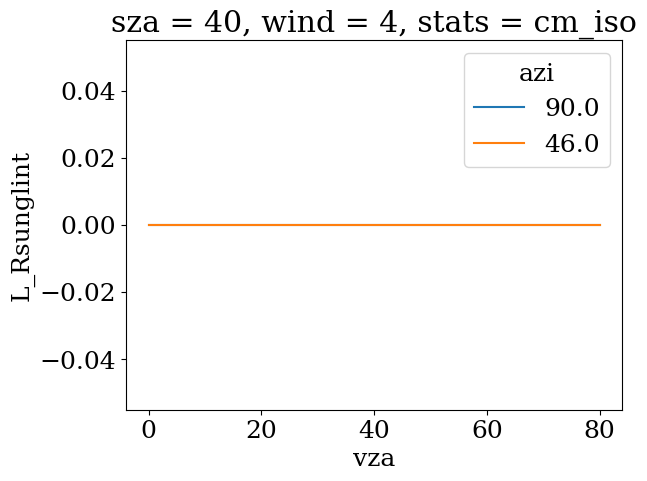

In [37]:
Rsunglint.L_Rsunglint.sel(azi=[90,46]).plot(hue="azi")

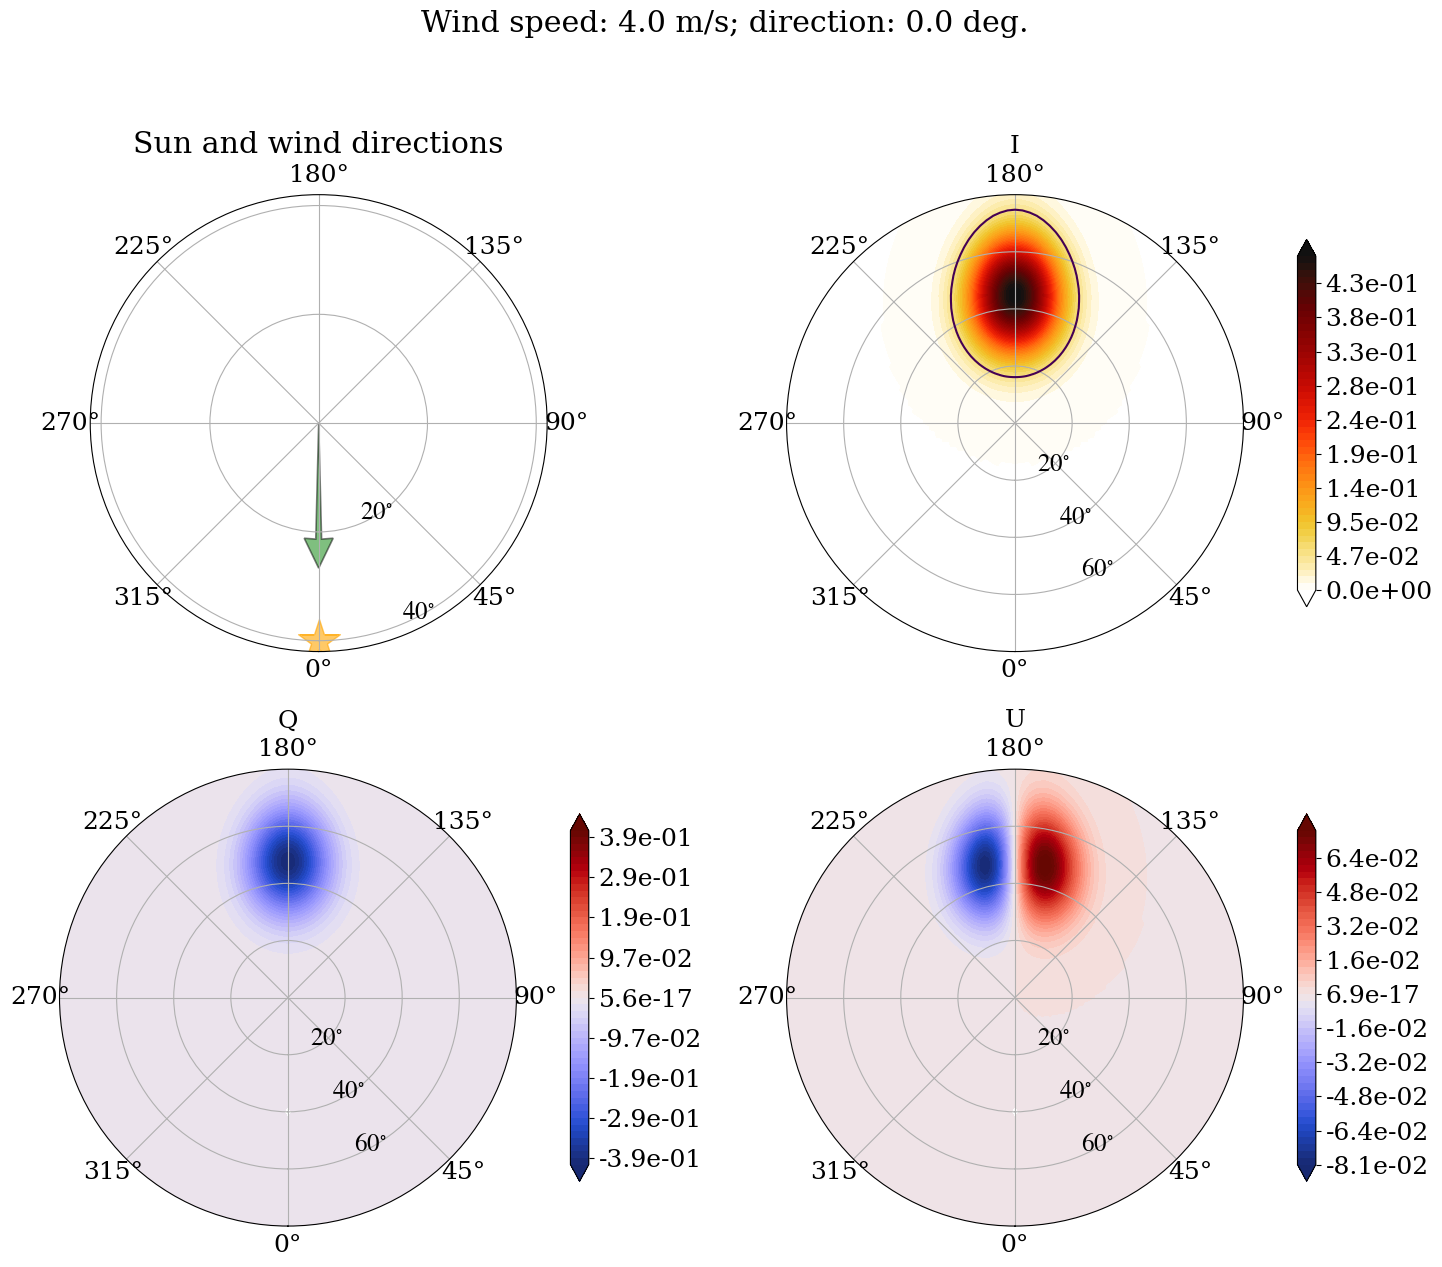

In [15]:
# ------------------
# plotting section
# ------------------


fig, axs = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection='polar'), figsize=(15, 13))
axs = axs.ravel()


cmap = cc.cm.linear_kryw_5_100_c64_r
if slope:
    for i, title in enumerate(titles):
        
        if title in ('Pdist','$R_f$', 'Q', 'I'):
            cmap_sym = False

        coxmunk.plot().add_polplot(axs[i], vza, azi, data[..., i].T, title=title, cmap=cmap, cmap_sym=cmap_sym)
else:
    axs[0].set_title('Sun and wind directions', pad=30)


    for i, title in enumerate(titles):
        cmap_sym = True
        cmap = cc.cm.CET_D1A
        
            
        if title in ('Pdist','$R_f$',  'I'):
            cmap = cc.cm.linear_kryw_5_100_c64_r
            cmap_sym = False
            axs[i + 1].contour(np.radians(azi),vza, data[..., i].T, [0.05])

        coxmunk.plot().add_polplot(axs[i + 1], vza, azi, data[..., i].T, title=title, cmap=cmap, cmap_sym=cmap_sym)
        
    # I=data[...,0].T
# Q=data[...,1].T
# U=data[...,2].T
# DOP = np.sqrt(Q**2+U**2)#/I
# plot().add_polplot(axs[3], vza, azi, DOP, title='DOP', cmap=cmap)
axs[0].scatter([0], [sza], marker='*', facecolor='orange', alpha=0.6, s=1000)
coxmunk.plot().label_polplot(axs[0], yticks=[20., 40., 60., 80.],
                     ylabels=['$20^{\circ}$', '$40^{\circ}$', '$60^{\circ}$', ''])
l_arrow = np.max(vza) * max(3, min(16, wind)) / 15

axs[0].arrow(wind_azi * np.pi / 180, 0, 0, l_arrow, alpha=0.5, width=0.05, head_width=0.25,
             head_length=l_arrow / 4,
             edgecolor='black', facecolor='green', lw=1.2)
plt.suptitle(r'Wind speed: {:.1f} m/s; direction: {:.1f} deg.'.format(wind, wind_azi))
plt.tight_layout(rect=[0.0, 0.0, 0.99, 0.95])

In [19]:
values= data
nlayers=50
min_, max_ = values.min(), values.max()
if np.abs(min_) < 1e-6:
    min_ = 0

if cmap_sym:
    val = max(abs(min_), max_)
    min_ = -val
    max_ = val

# debug
if max_ - min_ == 0:
    max_ = min_ + 1
inc = (max_ - min_) / nlayers
contour = np.arange(min_, max_, inc)

In [38]:
min_

nan

In [39]:
max_

nan

In [41]:
np.nanmax(values)


4.638782108752922